# Recent developments and user contributions in zfit.

With version 0.20, zfit prepares for a more stable and user-friendly interface. This talk will demonstrate the most significant changes. It is meant for people who are already somewhat familiar with zfit (even from the last tutorial) and want to upgrade their  code.

**Not all changes are everywhere reflected in the docs, [help with the docs is welcome](https://github.com/zfit/zfit/issues/556)** as well as [adding a more polished PDF](https://github.com/zfit/zfit/issues/512). (See [all issues with contributions wanted](https://github.com/zfit/zfit/issues?q=is%3Aissue+is%3Aopen+sort%3Aupdated-desc) or [reach out](https://github.com/zfit/zfit#contact) to us on Mattermost, Gitter, GitHub, or e-mail if you're interested **in becoming a contributor**, from beginners to advanced).

In [1]:
import numpy as np

# standard imports
import zfit
import zfit.z.numpy as znp  # use this "numpy-like" for mathematical operations
import zfit_physics as zphys  # physics module, with new physics-inspired PDFs
from zfit import z

/Users/iason/fun/pyhep2024-zfit-recent-developments/.venv/lib/python3.11/site-packages/zfit/__init__.py:59: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


Note: Please use `znp` if possible.

## Parameters

The largest upgrade comes from parameters: `NameAlreadyTakenError` is gone! Multiple parameters with the same name can now be created and co-exist. The only limit is: they must not exist within the same PDF/loss etc., as this would lead to ambiguities. This means that you can also rerun cells that define parameters without the need to restart the kernel.

In [2]:
param1 = zfit.Parameter("param1", 1, 0, 10)
param1too = zfit.Parameter("param1", 2, 0, 10)
# no error!

### Updated params

The minimizer currently updates the parameter default values after each minimization. To keep this behavior, add `update_params()` call after the minimization.

(experimentally, the update can be disabled with `zfit.run.experimental_disable_param_update(True)`, this will probably be the default in the future. Pay attention that using this experimental features most likely breaks current scripts. Feedback on this new feature is highly welcome!)

In [3]:
obs = zfit.Space("x", limits=(-10, 10))

# create the model
mu = zfit.Parameter("mu", 2.4, -1, 5)
sigma = zfit.Parameter("sigma", 1.3, 0, 5)
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)

# load the data
data_np = np.random.normal(size=10000)
data = zfit.Data.from_numpy(obs=obs, array=data_np)

# build the loss
nll = zfit.loss.UnbinnedNLL(model=gauss, data=data)

# minimize
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll).update_params()
result

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.Data: Data obs=('x',) shape=(10000, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 4.9e-08 │         14315.44 | -7525.662 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
mu              0.00334129       False
sigma              1.01269       False

## Serialization

The result can now be pickled like any object in zfit!
(this was not possible before, only after calling `freeze` on the result)
 
This works directly using `dill` (a library that extends `pickle`), but can fail if the garbage collector is not run. Therefore, zfit provides a slightly modified `dill` that can work as a drop-in replacement.

The objects can be saved and loaded again and used as before. Ideal to store the minimum of a fit and use it later for statistical treatments, plotting, etc.

In [4]:
result_serialized = zfit.dill.dumps(result)
result_deserialized = zfit.dill.loads(result_serialized)

In [5]:
# the result can be used as before
result_deserialized.hesse()  # the default name is now "hesse" and not "minuit_hesse"
result_deserialized.errors()  # the default name is now "errors" and not "minuit_minos"
print(result_deserialized)

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.Data: Data obs=('x',) shape=(10000, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 4.9e-08 │         14315.44 | -7525.662 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)        hesse               errors    at limit
------  ------------------  -----------  -------------------  ----------
mu              0.00334129  +/-    0.01  -   0.01   +   0.01       False
sigma              1.01269  +/-  0.0072  - 0.0071   + 0.0072       False


## Labels

Many objects, including parameters, can now have a label. This label is purely human-readable and can be used for plotting, printing, etc. It can contain arbitrary characters.

The `name` of objects still exists and will in a future version probably be used for identification purpose (in conjunction with serialization). Therefore, use `label` for human-readable names and avoid `name` for that purpose.

In [6]:
param1again = zfit.Parameter("param1", 3, 0, 10, label=r"$param_1$ [GeV$^2$]")

## Space

As explained [in the github discussion thread](https://github.com/zfit/zfit/discussions/533) there are major improvements and changes.
- multispaces (adding two spaces, having disjoint observables) are now deprecated and will be removed. The new `TruncatedPDF` supports multiple spaces as limits and achieves a similar, if not better, functionality.
- the return type of `Space.limit` will be changed in the future. For forwards compatibility, use `Space.v1.limit` (or similar methods) instead of `Space.limit`. The old one is still available via `Space.v0.limit`.
- new ways of creating spaces

More [examples on how to use the new spaces](https://github.com/zfit/zfit/blob/develop/examples/spaces.py).

In [7]:
obs1 = zfit.Space("obs1", -1, 1)  # no tuple needed anymore
obs2 = zfit.Space("obs2", lower=-1, upper=1, label="observable two")

# create a space with multiple observables
obs12 = obs1 * obs2

In [8]:
# limits are now as one would naively expect, and area has been renamed to volume (some are tensors, but that doesn't matter: they behave like numpy arrays)
print(f"old: limits={obs12.v0.limits}")
print(f"new: limits={obs12.v1.limits}")  # we have just 1D arrays

old: limits=(array([[-1., -1.]]), array([[1., 1.]]))
new: limits=(<tf.Tensor: shape=(2,), dtype=float64, numpy=array([-1., -1.])>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.])>)


In [9]:
# this allows, for example, for a more intuitive way
print(np.linspace(*obs12.v0.limits, num=7).shape)
print(np.linspace(*obs12.v1.limits, num=7).shape)
np.linspace(*obs12.v1.limits, num=7)

(7, 1, 2)
(7, 2)


array([[-1.        , -1.        ],
       [-0.66666667, -0.66666667],
       [-0.33333333, -0.33333333],
       [ 0.        ,  0.        ],
       [ 0.33333333,  0.33333333],
       [ 0.66666667,  0.66666667],
       [ 1.        ,  1.        ]])

## Data

Data handling has been significantly simplified and streamlined.
- all places (or most) take directly `numpy` arrays, tensors or `pandas DataFrame` as input, using a `Data` object is not necessary anymore (but convenient, as it cuts the data to the space)
- `Data` objects can now be created without the specific constructors (e.g. `zfit.Data.from_pandas`), but directly with the data. The constructors are still available for convenience and for more options.
- `Data` objects are now stateless and offer instead `with`-methods to change the data. For example, `with_obs`, `with_weights` (can be `None` to have without weights) etc.
- The `SamplerData` has been overhauld and has now a more public API including a `update_data` method that allows to change the data without creating a new object and without relying on a `create_sampler` method from a PDF.
- `zfit.data.concat` has been added to concatenate data objects, similar to `pd.concat`.

In [10]:
data1_obs1 = zfit.Data(np.random.uniform(0, 1, 1000), obs=obs1)
data1_obs2 = zfit.Data(
    np.random.uniform(0, 1, 1000), obs=obs2, label="My favourite $x$"
)
data2_obs1 = zfit.Data(np.random.normal(0, 1, 1000), obs=obs1)

# similar like pd.concat
data_obs12 = zfit.data.concat([data1_obs1, data1_obs2], axis="columns")
data_obs1 = zfit.data.concat([data1_obs1, data2_obs1], axis="index")

In [11]:
# data can be accessed with "obs" directly
data_obs12["obs1"]  # returns a numpy array shape (n,)
data_obs12[["obs2", "obs1"]]  # returns a numpy array shape (n, 2)

<tf.Tensor: shape=(1000, 2), dtype=float64, numpy=
array([[0.08341046, 0.80347605],
       [0.66765008, 0.50110249],
       [0.50354534, 0.49786352],
       ...,
       [0.42548589, 0.1400988 ],
       [0.52508943, 0.96477593],
       [0.54233952, 0.11564967]])>

## Binning

Using a binned space has now the effect of creating a binned version. This happens for `Data` and `PDF` objects.

In [12]:
obs1 = zfit.Space("obs1", -1, 1)
obs1_binned = obs1.with_binning(12)
data_binned = zfit.Data(np.random.normal(0, 0.2, 1000), obs=obs1_binned)

## PDFs

- there are a plethora of new PDFs, mostly covering physics inspired use-cases. Amongst the interesting ones are a `GeneralizedCB`, a more general version of the `DoubleCB` that should be preferred in the future. A Voigt profile is available, Bernstein polynomials, QGauss, GaussExpTail, etc. and in [zfit-physics](https://zfit.readthedocs.io/en/latest/user_api/zfit.pdf.html#physics-pdfs) HEP specific PDFS , from `CMSShape`, `Cruijff`, `Novosibirsk` and more. 
- the `TruncatedPDF` has been added to allow for a more flexible way of truncating a PDF. Any PDF can be converted to a truncated version using `to_truncated` (which, by default, truncates to the limits of the space).
- PDFs have a new `plot` method that allows for a quick plotting of the PDF (it takes an "obs" argument that allows to simply project it!). This is still experimental and may changes, the main purpose is to allow for a quick check of the PDF in interactive environments. The function is fully compatible with matplotlib and takes an `ax` argument, it also allows to pass through any keyword arguments to the plotting function.

In [13]:
print(zfit.pdf.__all__)

['BasePDF', 'BaseFunctor', 'Exponential', 'Voigt', 'CrystalBall', 'DoubleCB', 'GeneralizedCB', 'GaussExpTail', 'GeneralizedGaussExpTail', 'Gauss', 'BifurGauss', 'Uniform', 'TruncatedGauss', 'WrapDistribution', 'Cauchy', 'Poisson', 'QGauss', 'ChiSquared', 'StudentT', 'Gamma', 'Bernstein', 'Chebyshev', 'Legendre', 'Chebyshev2', 'Hermite', 'Laguerre', 'RecursivePolynomial', 'ProductPDF', 'SumPDF', 'GaussianKDE1DimV1', 'KDE1DimGrid', 'KDE1DimExact', 'KDE1DimFFT', 'KDE1DimISJ', 'FFTConvPDFV1', 'ConditionalPDFV1', 'ZPDF', 'SimplePDF', 'SimpleFunctorPDF', 'UnbinnedFromBinnedPDF', 'BinnedFromUnbinnedPDF', 'HistogramPDF', 'SplineMorphingPDF', 'BinwiseScaleModifier', 'BinnedSumPDF', 'SplinePDF', 'TruncatedPDF', 'LogNormal', 'CachedPDF']


In [14]:
print(zphys.pdf.__all__)

['Argus', 'RelativisticBreitWigner', 'CMSShape', 'Cruijff', 'ErfExp', 'Novosibirsk', 'Tsallis']


/var/folders/2c/94kt72fs0_q_9nzr2y5jphb00000gn/T/ipykernel_11946/497843262.py:8: ExperimentalFeatureWarning: The function <function assert_initialized.<locals>.wrapper at 0x318915b20> is EXPERIMENTAL, potentially unstable and likely to change in the future! Use it with caution and feedback (Gitter, Mattermost, e-mail or https://github.com/zfit/zfit/issues) is very welcome!
  pdf.plot.plotpdf()  # quick plot


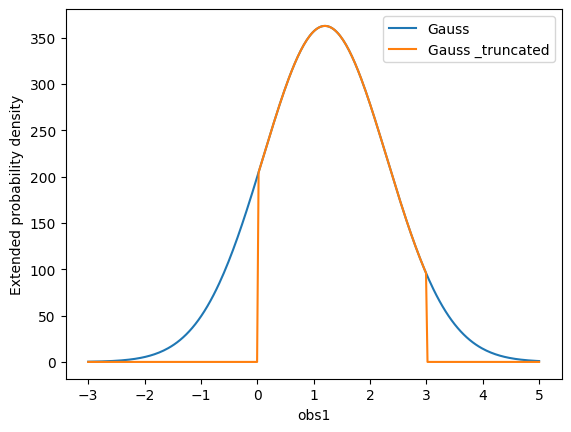

In [15]:
# create a PDF
obs1 = zfit.Space("obs1", -3, 5)
mu = zfit.Parameter("mu", 1.2)
sigma = zfit.Parameter("sigma", 1.1)
pdf = zfit.pdf.Gauss(
    mu=mu, sigma=sigma, obs=obs1, extended=1000
)  # using an extended PDF, the truncated pdf automatically rescales
pdf.plot.plotpdf()  # quick plot
# truncate it
pdf_truncated = pdf.to_truncated(limits=(0, 3))
pdf_truncated.plot.plotpdf();

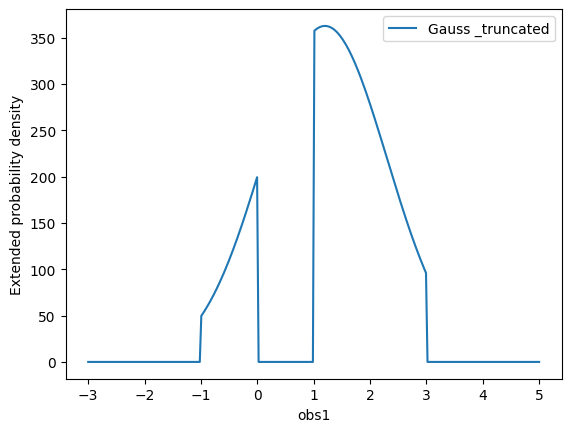

In [16]:
# a truncated PDF can also have multiple limits, replacing the MultiSpace concept
range1 = zfit.Space(
    "obs1", -1, 0, label="lower range"
)  # an excellent use-case of a label
range2 = zfit.Space("obs1", 1, 3, label="upper range")
pdf_disjoint = pdf.to_truncated(limits=(range1, range2))
pdf_disjoint.plot.plotpdf();

In [17]:
# binned pdfs from space work like the data
gauss_binned = zfit.pdf.Gauss(
    mu=zfit.Parameter("mu", 2.5),
    sigma=zfit.Parameter("sigma", 1.1),
    obs=obs1_binned,
    extended=1000,
)

/Users/iason/fun/pyhep2024-zfit-recent-developments/.venv/lib/python3.11/site-packages/zfit/models/tobinned.py:71: AdvancedFeatureWarning: Either you're using an advanced feature OR causing unwanted behavior. To turn this warning off, use `zfit.settings.advanced_warnings['extend_wrapped_extended'] = False`  or 'all' (use with care) with `zfit.settings.advanced_warnings['all'] = False
PDF Gauss Gauss is already extended, but extended also given 1000. Will use the given yield.
  warn_advanced_feature(


In [18]:
print(pdf.pdf(data_obs1.to_numpy()))
print(pdf.pdf(data_obs1.to_pandas()))

tf.Tensor([0.33997697 0.2964882  0.29593276 ... 0.15781825 0.11079488 0.12518359], shape=(1685,), dtype=float64)
tf.Tensor([0.33997697 0.2964882  0.29593276 ... 0.15781825 0.11079488 0.12518359], shape=(1685,), dtype=float64)


## Parameters as arguments

The values of the parameters can now be directly used as arguments in functions of PDFs/loss. Methods in the pdf also take the parameters as arguments.

The name of the argument has to match the name of the parameter given in initialization (or can also be the parameter itself).

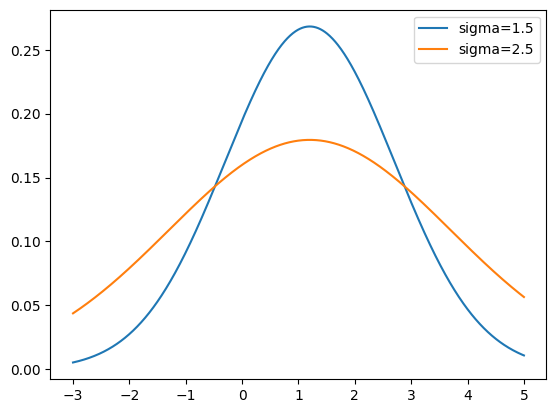

In [19]:
from matplotlib import pyplot as plt

x = znp.linspace(*obs1.v1.limits, 1000)
plt.plot(x, pdf.pdf(x, params={"sigma": 1.5}), label="sigma=1.5")
plt.plot(x, pdf.pdf(x, params={sigma: 2.5}), label="sigma=2.5")
plt.legend()
plt.show()

## How to write your own PDF

In [20]:
class MyGauss(zfit.pdf.BasePDF):
    def __init__(self, mean, std, obs, extended=None, norm=None, name=None, label=None):
        params = {
            "mean": mean,  # 'mean' is the name as it will be named in the PDF, mean is just the parameter to create the PDF
            "std": std,
        }
        super().__init__(
            obs=obs, params=params, extended=extended, norm=norm, name=name, label=label
        )

    @zfit.supports()  # this allows the params magic
    def _unnormalized_pdf(self, x, params):
        x0 = x[0]  # using the 0th axis
        mean = params["mean"]
        std = params["std"]
        return z.exp(-(((x0 - mean) / std) ** 2))

In [21]:
obs = zfit.Space("obs1", -3, 6)
data_np = np.random.random(size=1000)
data = zfit.Data(data_np, obs=obs)
mean = zfit.Parameter("mean", 1.0)
std = zfit.Parameter("std", 1.0)
my_gauss = MyGauss(obs=obs, mean=mean, std=std)
my_gauss.pdf(data)[:20]

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([0.30058698, 0.38976821, 0.54148486, 0.22375747, 0.51414397,
       0.20841814, 0.56060405, 0.44988246, 0.53459402, 0.27695495,
       0.24309867, 0.31592892, 0.37713048, 0.45234244, 0.51240541,
       0.37541017, 0.32950433, 0.41733352, 0.40195437, 0.25510752])>

In [22]:
def gauss_integral_from_any_to_any(limits, params, model):
    lower, upper = limits.v1.limits
    mean = params["mean"]
    std = params["std"]
    # write your integral here
    return mean * std  # dummy integral, must be a scalar!

In [23]:
limits = zfit.Space(axes=0, lower=zfit.Space.ANY_LOWER, upper=zfit.Space.ANY_UPPER)
MyGauss.register_analytic_integral(func=gauss_integral_from_any_to_any, limits=limits)

In [24]:
import tensorflow_probability as tfp


class JohnsonSU(zfit.pdf.WrapDistribution):
    _N_OBS = 1

    def __init__(
        self,
        mu,
        lambd,
        gamma,
        delta,
        obs,
        extended=None,
        norm=None,
        name="JohnsonSU",
        label=None,
    ):
        mu, lambd, gamma, delta = self._check_input_params_tfp(mu, lambd, gamma, delta)
        params = {"mu": mu, "lambd": lambd, "gamma": gamma, "delta": delta}

        def dist_params():
            return {
                "skewness": gamma.value(),
                "tailweight": delta.value(),
                "loc": mu.value(),
                "scale": lambd.value(),
            }

        distribution = tfp.distributions.JohnsonSU
        super().__init__(
            distribution=distribution,
            dist_params=dist_params,
            obs=obs,
            params=params,
            name=name,
            extended=extended,
            norm=norm,
            label=label,
        )

In [25]:
obs = zfit.Space("obs1", 1, 10)
data_np = np.random.uniform(low=1, high=10, size=1000)
data = zfit.Data(data_np, obs=obs)
mu = zfit.Parameter("mu", 8.0)
lambd = zfit.Parameter("std", 4.0)
gamma = zfit.Parameter("gamma", 2.0)
delta = zfit.Parameter("delta", 3.0)
my_johnson = JohnsonSU(obs=obs, mu=mu, lambd=lambd, gamma=gamma, delta=delta)
my_johnson.pdf(data)[:20]

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([0.12538851, 0.14123544, 0.0320667 , 0.25071288, 0.04293916,
       0.05108749, 0.07121504, 0.09947468, 0.20712774, 0.13781783,
       0.22816785, 0.07886887, 0.25187544, 0.02398333, 0.1142482 ,
       0.01088529, 0.00179776, 0.21686711, 0.00083144, 0.01811153])>